In [1]:
import sys
sys.path.append('/global/homes/p/portmanm/timedomain/gwtarget/')

from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique, setdiff
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle
from astropy.time import Time

from gw_skymap import plot_mollmap, compute_quantiles, compute_contours #plot_cartmap
from desitarget import io, cuts

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
global exposure_path
exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"

global today
today = Time.now()

# From https://github.com/desihub/timedomain/blob/master/gwtarget/gw_skymap.py
# Because I was having trouble importing again

def compute_quantiles(proportions, samples):
    """Get quantiles of HEALPix probability map.

    Parameters:
    -----------
    proportions: list
        list of containment level to make contours for.
        E.g [0.68,0.9]
    samples: array
        array of values read in from healpix map
        E.g samples = hp.read_map(file)

    Returns:
    --------
    levels: list
        List of map values corresponding to a given containment level.
    """
    levels = []
    sorted_samples = list(reversed(list(sorted(samples))))
    nside = hp.pixelfunc.get_nside(samples)
    sample_points = np.array(hp.pix2ang(nside,np.arange(len(samples)))).T
    for proportion in proportions:
        level_index = (np.cumsum(sorted_samples) > proportion).tolist().index(True)
        level = (sorted_samples[level_index] + (sorted_samples[level_index+1] if level_index+1 < len(samples) else 0)) / 2.0
        levels.append(level)
    return levels

In [2]:
# From decam_TAMU_ledgermaker.ipynb - https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Thanks Antonella!

def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False, tabformat='TAMU'):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    with open(filename, mode) as outf:
        if overwrite:
            outf.write("""# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID\n""")
            
        today = Time.now()
        datedict = {}
        reporting = ['DESIRT','DDF','ALERCE']
        
        if tabformat=='TAMU':
            for i in range(too_table.shape[0]):

                row=too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA-OBJECT'], dec=row['DEC-OBJECT'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['Discovery-Time'], scale='utc')

                mag  = row['Discovery-Magnitude']
                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'DESIRT'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
                
        if tabformat=='ddf':
            for i in range(too_table.shape[0]):

                row=too_table[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = today.mjd #Do not have discovery time so using today

                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc) 
                reporter = 'DDF'
                reporting_id=2
                mjd_exp = 100*mjd_disc + reporting_id
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc, t_disc+14, too_id))
                
        if tabformat=='ALERCE':
            for i in range(too_table.shape[0]):

                row = too_table.iloc[i]           
                coord = SkyCoord(ra=row['meanra'], dec=row['meandec'], unit=(u.degree, u.degree))
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['lastmjd'], format = 'mjd')

                #mag  = row['Discovery-Magnitude']
                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'ALERCE'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                    
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())
                
    return None

In [3]:
# Borrowed from gw_skymap.py to be modified

def plot_cartmap(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')

    _h, _l = ax.get_legend_handles_labels()

#     # Add DESI tile drawings, specified by central RA, Dec.
#     if tile_ra is not None and tile_dec is not None:
#         for _ra_c, _dec_c in zip(tile_ra, tile_dec):
#             circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
#             ax.add_artist(circ)

#         _h.append(circ)
#         _l.append('DESI FOV')

    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5) # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

In [4]:
# From ALeRCE_ledgermaker https://github.com/alercebroker/alerce_client
# I have had trouble importing this before so here it goes
# Now modified ***
import requests
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import pandas as pd
from alerce.core import Alerce
from alerce.exceptions import APIError

alerce_client = Alerce()

def access_alerts(lastmjd_in=None, ra_in = None, dec_in = None, search_radius = None, classifier='stamp_classifier', class_names=['SN', 'AGN']):
    if type(class_names) is not list:
        raise TypeError('Argument `class_names` must be a list.')
        
    dataframes = []
    if not lastmjd_in:
        date_range = 60
        lastmjd_in = Time.now().mjd - 60
        print('Defaulting to a lastmjd range of', str(date_range), 'days before today.')
        
    for class_name in class_names:
        data = alerce_client.query_objects(classifier=classifier,
                                           class_name=class_name, 
                                           order_by='oid',
                                           order_mode='DESC',
                                           page_size=5000,
                                           lastmjd=lastmjd_in,
                                           ra=ra_in,
                                           dec=dec_in,
                                           radius=search_radius,
                                           format='pandas')
        
        #if lastmjd is not None:
        #    select = data['lastmjd'] >= lastmjd
        #    data = data[select]
            
        dataframes.append(data)
    
    return pd.concat(dataframes).sort_values(by='lastmjd')

In [5]:
def read_gwfile(filepath: str, hdu_num = 1):
    
    properties = {}
    
    try:
        with fits.open(filepath) as hdu1:
    
            hdr = hdu1[hdu_num].header
        
            properties["mjd"] = hdr["MJD-OBS"]
            properties["nside"] = hdr["NSIDE"]
            properties["nest"] = True if hdr["ORDERING"] == "NESTED" else False #save myself some time here
            
            data_table = Table(hdu1[hdu_num].data) #columns
            properties["prob"] = data_table["PROB"].data
        
            #targ_id = data_table['TARGETID']
            #targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            #targ_dec = data_table['TARGET_DEC'].data
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file if it exists...")
        return properties #np.array([]), np.array([]), np.array([])
    
    #if transient_candidate:
    #    targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
    #    targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
    #    targ_mjd = Time(targ_mjd).mjd
    
    return properties #targ_ra, targ_dec, targ_mjd

In [6]:
# Borrowed from 'find_map_pixels.py', thanks Antonella!
def prob_pixel_locs(gw_in: dict, percentile = [0.9]):
    
    all_idx = []
    
    sort_percentile = sorted(percentile)
    max_percentile = sort_percentile[-1]
    #npix = len(gw_map)
    pb = gw_in["prob"] #hs.data['PROB']
    NSIDE = gw_in["nside"]
    idx_sort = np.argsort(pb)
    idx_sort_up = list(reversed(idx_sort))
    sum = 0.
    id = 0
    p_idx = 0
    #for p in percentile:
    
    while sum < 1:
        
        this_idx = idx_sort_up[id]
        sum += pb[this_idx]
        id += 1
        
        if sum >= percentile[p_idx]:
            all_idx.append(idx_sort_up[:id])
            p_idx += 1
            
            if p_idx > len(percentile) - 1:
                break
    
    for i in range(len(sort_percentile)):
        area = hp.nside2pixarea(gw_in['nside'], degrees=True)*len(all_idx[i])
        print("The ", percentile[i]*100. ,"% map is ",area," deg^2", sep = '')

    return all_idx

with fits.open(gwfile) as hdu1:
    hdr = hdu1[1].header
    print(hdr["MJD-OBS"])

In [7]:
gwfile = 'GW190412_combined_skymap.fits.gz'
gw_name = gwfile.split('_')[0]
gw_properties = read_gwfile(gwfile)
ra_max, dec_max = hp.pix2ang(gw_properties["nside"], np.argmax(gw_properties["prob"]), nest = gw_properties["nest"], lonlat = True)
#print(ra_max, dec_max)

print(Time.now().mjd - 60, ':', Time.now().mjd)
print(len(alerts))
x = []
#print(sorted(alerts['oid']))
for i in range(len(alerts['oid'])):
    x.append(alerts['oid'].iloc[i])
    #if alerts['oid'].iloc[i].startswith('ZTF21aarzs'):
    #    print(i, alerts.iloc[i])

print(sorted(x)[:10])
print(sorted(x)[-11:-1])
#print(type(alerts['oid'].iloc[0]))

In [8]:
gw_map = hp.read_map(gwfile, nest = gw_properties["nest"])
gw_properties = read_gwfile(gwfile)
ra_max, dec_max = hp.pix2ang(gw_properties["nside"], np.argmax(gw_properties["prob"]), nest = gw_properties["nest"], lonlat = True)
#print(ra_max, dec_max)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

fig = plot_mollmap(gwfile, rot = 120, path_to_mask = '/global/u2/p/portmanm/timedomain/gwtarget/')
#projplot(alerts_ra, alerts_dec, lonlat = True, rot = 120)

fig = plot_cartmap(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = alerts_ra, targ_dec = alerts_dec, angsize = 3)
#fig = plt.figure()
ax = fig.gca()
ax.set(xlim=(221, 214), ylim=(33,39))

In [9]:
pix90, pix95 = prob_pixel_locs(gw_properties, percentile = [0.9, 0.95])

The 90.0% map is 18.985740232101044 deg^2
The 95.0% map is 30.15227990237149 deg^2


In [10]:
# Area of 90% C.I.
# Still something wonky here... not matching Segev's values but I'll take it for now seeing as how it's not super important
npix = len(gw_map)
radius = len(pix90)/npix
area = 4*np.pi*radius * (180/np.pi)**2
print('A = {:.1f} deg^2'.format(area))
#area *= u.deg
rad_arcsec = np.sqrt(area/(4*np.pi))*3600


A = 19.0 deg^2


In [11]:
# At the moment assumes a single blob
# Need to account for multiple localizations
# Check out hp function, https://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.ud_grade.html?highlight=degrade
# Downgrade map to NSIDE 32 and then check 95% range, then feed to alerce pixel by pixel (use radius of pixel size per https://lambda.gsfc.nasa.gov/toolbox/tb_pixelcoords.cfm)
# Remove duplicates :) 

alerts_sn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra_max, dec_in = dec_max, search_radius = 4*rad_arcsec, class_names = ['SN']) # In practice, 4*rad_arcsec covers any wonky shape we can come up with
alerts_agn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra_max, dec_in = dec_max, search_radius = 4*rad_arcsec, class_names = ['AGN']) # In practice, 4*rad_arcsec covers any wonky shape we can come up with
# in reality will be time of GW event and now
#gw_properties["mjd"] + 30)
alerts_sn_ra = alerts_sn['meanra'].to_numpy()
alerts_sn_dec = alerts_sn['meandec'].to_numpy()

alerts_agn_ra = alerts_agn['meanra'].to_numpy()
alerts_agn_dec = alerts_agn['meandec'].to_numpy()
#print(alerts.columns)
print(alerts_sn.size)
print(alerts_agn.size)

1472
32108


In [12]:
# Load sample of resolved DR9 target catalog using HEALPixels above threshold in the GW map.
# Get list of pixels above threshold defined by level.
#gwmap = hp.read_map(gwfile)
#npix = len(gwmap)
#nside = hp.npix2nside(npix)

#tree_name = "kdtree_" + str(today - 30)

#theta_array = np.pi/180*(90 - alerts_dec)
#phi_array = np.pi/180*alerts_ra

transient_pix_locs_sn = hp.ang2pix(gw_properties["nside"], alerts_sn_ra, alerts_sn_dec, lonlat = True, nest = gw_properties["nest"])
transient_pix_locs_agn = hp.ang2pix(gw_properties["nside"], alerts_agn_ra, alerts_agn_dec, lonlat = True, nest = gw_properties["nest"])
#print(transient_pix_locs.shape)

In [13]:
#vec90 = hp.pix2vec(gw_properties["nside"], pix90, nest = gw_properties["ordering"])
#poly_pix = hp.query_polygon(gw_properties["nside"], vec90, inclusive = True, nest = gw_properties["ordering"])
#print(sorted(poly_pix))
#print(sorted(transient_pix_locs))
#print(sorted(poly_pix))

# Per https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr8.ipynb
#hp.ring2nest(gw_properties["nside"],
trans_in_prob_region_sn = np.isin(transient_pix_locs_sn, pix90) #np.intersect1d(transient_pix_locs, poly_pix)
trans_in_prob_region_agn = np.isin(transient_pix_locs_agn, pix90) #np.intersect1d(transient_pix_locs, poly_pix)

#print(trans_in_prob_region.shape)
ra_sn, dec_sn = hp.pix2ang(gw_properties["nside"], transient_pix_locs_sn[trans_in_prob_region_sn], nest = gw_properties["nest"], lonlat = True)
ra_agn, dec_agn = hp.pix2ang(gw_properties["nside"], transient_pix_locs_agn[trans_in_prob_region_agn], nest = gw_properties["nest"], lonlat = True)

if np.any(trans_in_prob_region_sn):
    #print("Any SN matches?", np.any(trans_in_prob_region_sn))
    print(len(ra_sn), "SN matches")
    print(len(ra_agn), "AGN matches")

14 SN matches
313 AGN matches


In [14]:
alerce_matches = SkyCoord(ra_sn*u.deg, dec_sn*u.deg) #SkyCoord(list(zip(ra_sn, dec_sn)))
#print(list(zip(ra_sn, dec_sn)))
ledger_ra = alerts_sn.loc[:,"meanra"].to_numpy()
ledger_dec = alerts_sn.loc[:,"meandec"].to_numpy()
# print(alerce_ra_dec[:10])

# idx_alerts = [i for i, val in enumerate(alerce_ra_dec) if val[0] in ra_sn and val[1] in dec_sn]

# for i, val in enumerate(alerce_ra_dec):
#     if val[0] in ra_sn and val[1] in dec_sn:
#         print("yay")

coo_ledger = SkyCoord(ledger_ra*u.deg, ledger_dec*u.deg)

idx_alerts, temp1, _ = match_coordinates_sky(alerce_matches, coo_ledger) # Not overkill... converting to and from pixels is not an exact operation!

sep_constraint = temp1 <= 0.05*u.deg
#trans_matches = coo_trans_search[sep_constraint]
ledger_matches = coo_ledger[idx_alerts[sep_constraint]]
#print(ledger_matches)

assert len(ledger_matches) == len(alerce_matches), "Something went wrong grabbing the matches from the original catalog! Stopping (1)."

ledger_ra_dec = list(zip(ledger_ra, ledger_dec))
idx_alerts = [i for i, val in enumerate(ledger_ra_dec) if val[0] in ledger_matches.ra.deg and val[1] in ledger_matches.dec.deg] # or use df.apply and lambda function... it's fast enough here
alerce_rows = alerts_sn.loc[idx_alerts, :].sort_values(by='lastmjd')

assert len(alerce_rows) == len(ra_sn), "Something went wrong grabbing the matches from the original catalog! Stopping (2)."
print(alerce_rows)

# for i in range(10):
#     print(alerce_matches[i].ra.deg) 
#     print(ledger_matches[i].ra.deg)#alerce_rows.iloc[i]["meanra"])

             oid ndethist  ncovhist  mjdstarthist    mjdendhist  corrected  \
17  ZTF21aazbfzr        1      1181  59339.286308  59339.286308      False   
44  ZTF20aajxfcy       30      1190  58642.256806  59349.295706      False   
26  ZTF21aarcldd      109      1605  59297.341609  59353.319607      False   
32  ZTF21aaitzix       45      1630  58248.291539  59353.349468       True   
5   ZTF21abcxvqd        1      1658  59364.322280  59364.322280      False   
4   ZTF21abdbtfb       99      3642  58605.393576  59365.299849       True   
19  ZTF21aaxthcj       79      1730  59334.221968  59368.298484      False   
7   ZTF21abcprql       23      2415  59362.260255  59377.299201      False   
9   ZTF21abcovxx       42      1696  59359.239838  59379.248426      False   
6   ZTF21abcpsjy       46      1769  59338.426782  59379.285405      False   
49  ZTF19aansypp      358      1764  58558.422847  59379.285405       True   
8   ZTF21abcowbx       40      1693  59358.392708  59379.288380 

In [15]:
# grab Alerce matches that correlate to desi matches and feed back in
write_too_ledger('testing_ToO-input.ecsv', alerce_rows, checker='MP/AP', overwrite=True, verbose=True, tabformat='ALERCE')

# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID
213.106484  34.432701 0.000000 0.000000 2000.0 MP/AP FIBER HI BRIGHT 59324.36761570 59392.10051863 593240201
215.200709  35.651916 0.000000 0.000000 2000.0 MP/AP FIBER HI BRIGHT 59339.2

ERROR! Session/line number was not unique in database. History logging moved to new session 111


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn

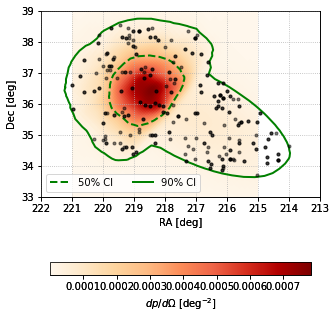

In [15]:
ra_list = [ra_sn, ra_agn]
dec_list = [dec_sn, dec_agn]
filename_suffix = ['SN', 'AGN']

for i in range(2):
    fig = plot_cartmap(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = ra_list[i], targ_dec = dec_list[i], angsize = 3)
    #fig = plt.figure()
    ax = fig.gca()
    ax.set(xlim=(222, 213), ylim=(33,39))
    plt.savefig(gw_name + '_alerce_' + filename_suffix[i] + '.png', dpi=120)

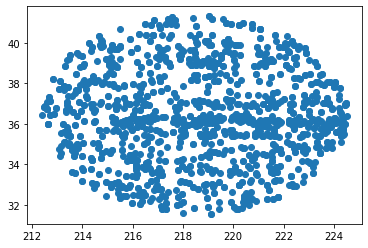

In [17]:
plt.scatter(alerts_ra, alerts_dec)
#hp.mollview(transient_pix_locs)
#twod_map = hp.mollview(gw_map, nest = True, rot = -110, cmap = "twilight", return_projected_map = True)
#print(twod_map.size)
#condition = np.isfinite(twod_map) #np.where(twod_map > 0.00000001) and np.isfinite(twod_map) #np.where(twod_map < 1000) # and twod_map < 10000)
#valid = np.extract(condition, twod_map)
#print(sum(twod_map[condition]))
#for i in twod_map[condition]:
#    if i > 0.0001:
#        print(i)

# Following the conventions here - https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb
npix = len(gw_map)
lev95, lev90 = compute_quantiles([0.95, 0.90], gw_map)#[0]
#print(lev90)
pixels = hp.ring2nest(gw_properties["nside"], np.arange(npix)) #np.arange(npix) 
pix95_2 = pixels[gw_map > lev95]
pix90_2 = pixels[gw_map > lev90]

#print(sum(gw_properties["prob"])) #[np.where(gw_properties["prob"] > 0.0001)]
#print(transient_pix_locs)

print(len(pix90))
print(len(pix90_2))
print(len(pix95))
print(len(pix95_2))

## Matching DESI observations to 95% contour

In [57]:
# From light_transient_matching, copy, pasted, and modified
def initial_check(skymap_ra_in, skymap_dec_in): #(ledger_df = None, ledger_type = ''):
    
    db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
    #exposure_path = os.environ["DESI_SPECTRO_REDUX"]
    
    #for obsdate,tile_number in obsdates_tilenumbers:
        #redux = '/'.join([os.environ['DESI_SPECTRO_REDUX'], args.redux, 'tiles'])
        #prefix_in = '/'.join([redux, tile_number, obsdate])

    # previous_date_ranges: "20201130" - "20210302"
    query_date_start = "20201201" #"20210228"
    
    today = Time.now()
    smushed_YMD = today.iso.split(" ")[0].replace("-","")
    
    query_date_end = smushed_YMD 

    query2 = "PRAGMA table_info(exposures)"
    query3 = "PRAGMA table_info(tiles)"
    # Crossmatch across tiles and exposures to grab obsdate via tileid
    query_match = "SELECT distinct tilera, tiledec, obsdate, obsmjd, expid, program, exposures.tileid from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        query_date_start + " AND " + query_date_end + ";" #obsdate>20210228 
    #query_dates = "SELECT obsdate from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        #query_date_start + " AND " + query_date_end + ";"

    conn = sqlite3.connect(db_filename)

    conn.row_factory = sqlite3.Row # https://docs.python.org/3/library/sqlite3.html#sqlite3.Row

    cur = conn.cursor()
    
#     cur.execute(query2)
#     row2 = cur.fetchall()
#     for i in row2:
#         print(i[:])
    #cur.execute(query)
    #rows = cur.fetchall()

    cur.execute(query_match)
    matches_list = cur.fetchall()
    cur.close()

    # I knew there was a way! THANK YOU!
    # https://stackoverflow.com/questions/11276473/append-to-a-dict-of-lists-with-a-dict-comprehension
    date_dict = {k['obsdate'] : list(filter(lambda x:x['obsdate'] == k['obsdate'], matches_list)) for k in matches_list}

    #cur.execute(query_dates)
    #dates = set(cur.fetchall())

    desi_matches_dict = {} #{i['obsdate']: [] for i in matches_list}

    #all_desi_matches = []
    all_confidence_matches = []
    
    #decam_transients = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')
    #if ledger_type.upper() == 'DECAM_TAMU':
    #    if ledger_df.empty:
    #        ledger_df = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')

    for date, row in date_dict.items():
        
        date_str = str(date)
        date_str = date_str[:4]+"-"+date_str[4:6]+"-"+date_str[6:] # Adding dashes for Time
        obs_mjd = Time(date_str).mjd

        # This method is *technically* safer than doing a double list comprehension with set albeit slower
        # The lists are small enough that speed shouldn't matter here
        # Should filter by unique tileid, not ras and decs because Dark and Bright could be on same (ra,dec)
        unique_tileid = {i['tileid']:(i['tilera'], i['tiledec']) for i in row}
        exposure_ras, exposure_decs = zip(*unique_tileid.values())
        
        #unique_ra_dec = list(set([(i[0], i[1]) for i in row])) # there's probably a way to do this in SQL... oh well
        #exposure_ras, exposure_decs = zip(*unique_ra_dec)
        
    # Change these to catalog_matches_1 and _2
        print(date)
        desi_matches, confidence_matches = inner_matching(exposure_ras_in = exposure_ras, exposure_decs_in = exposure_decs, 
                                                              ra_in = skymap_ra_in, dec_in = skymap_dec_in, 
                                                              query_dates = query_date_start + query_date_end,
                                                              max_sep = 2, sep_units = 'deg')
        if desi_matches.size:
            #print(len(row))
            #all_desi_matches.append(desi_matches)
            # To retrieve from SkyCoord into numpy float, x.ra.deg, x.dec.deg
            all_confidence_matches.extend(confidence_matches)
        else:
            continue

        desi_matches_dict[date] = []

        for tup in desi_matches:
            ra = tup.ra.deg
            dec = tup.dec.deg
            match_rows = [i for i in row if (i['tilera'], i['tiledec']) == (ra, dec)] # Just rebuilding for populating, this shouldn't change/exclude anything
            desi_matches_dict[date].extend(match_rows)
            
    return desi_matches_dict, all_confidence_matches

In [52]:
def inner_matching(exposure_ras_in = np.array([]), exposure_decs_in = np.array([]), ra_in = np.array([]), dec_in = np.array([]), 
                   max_sep = 2, sep_units = 'deg', query_dates = ""):
    
    if sep_units == 'arcsec':
        max_sep *= u.arcsec
    elif sep_units == 'arcmin':
        max_sep *= u.arcmin
    elif sep_units == 'deg':
        max_sep *= u.deg
    else:
        print("Separation unit specified is invalid for matching. Defaulting to arcsecond.")
        max_sep *= u.arcsec
        
    if not np.array(exposure_ras_in).size:
        print('Array of size 0 fed in. Returning no matches.')
        return np.array([]), np.array([])
    
    nan_ra = np.isnan(exposure_ras_in)
    nan_dec = np.isnan(exposure_decs_in)
    
    if np.any(nan_ra) or np.any(nan_dec):
        print("NaNs found, removing them from array (not FITS) before match.")
        #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
        nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
        exposure_ras_in = exposure_ras_in[nans] # Logic masking, probably more efficient
        exposure_decs_in = exposure_decs_in[nans]
        #print("Reduced length (ra, dec):", len(target_ras), len(target_decs))
        #print(np.where(np.isnan(target_ras) == True))
        #print(target_ras[:100])
        #print(np.where(np.isnan(target_decs) == True))
        #target_ras = np.delete(target_ras, nans)
        #target_decs = np.delete(target_decs, nans)
    
    tree_name = "_".join(("kdtree", query_dates))
    
    coo_trans_search = SkyCoord(exposure_ras_in*u.deg, exposure_decs_in*u.deg)
    coo_alerts = SkyCoord(ra_in*u.deg, dec_in*u.deg)

    idx_alerts, d2d_trans, d3d_trans = match_coordinates_sky(coo_trans_search, coo_alerts)#, storekdtree = tree_name) # store tree to speed up subsequent results

    sep_constraint = d2d_trans < max_sep
    trans_matches = coo_trans_search[sep_constraint]
    alerts_matches = coo_alerts[idx_alerts[sep_constraint]]
    
    if trans_matches.size:
        #sort_dist = np.sort(d2d_trans)
        print(len(trans_matches), "matches found with separation -", max_sep)
        #print("Minimum distance found: ", sort_dist[0])
        #print("5 closest (in case there's more than one): ", sort_dist[:5])
        #print()

    return trans_matches, alerts_matches

In [18]:
# Using 95% confidence skymap
ra_95, dec_95 = hp.pix2ang(gw_properties["nside"], pix95, lonlat = True)

In [19]:
#desi_matches, confidence_matches = initial_check(ra_95, dec_95)
desi_matches, _ = initial_check(ra_95, dec_95)

Minimum distance found:  1d35m31.1356s
Minimum distance found:  1d13m37.0836s
Minimum distance found:  1d13m37.0836s
Minimum distance found:  1d13m37.0836s
Minimum distance found:  1d13m37.0836s
Minimum distance found:  1d25m36.5678s
Minimum distance found:  1d05m29.8856s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  1d05m29.8856s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  1d05m29.8856s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  0d33m48.3985s
Minimum distance found:  0d33m48.3985s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  0d51m46.7174s
Minimum distance found:  1d32m34.0746s
Minimum distance found:  0d33m48.3985s
Minimum distance found:  0d33m48.3985s
Minimum distance found:  1d32m14.2829s
Minimum distance found:  0d33m48.3985s
Minimum distance found:  1d26m09.9887s
Minimum distance found:  

In [20]:
#print('tilera, tiledec, obsdate, obsmjd, expid, tileid')
tile_ras = []
tile_decs = []
program_info = []
count = 0
for k,v in desi_matches.items():
    for i in v:
        if i['tilera'] not in tile_ras and (i['program'] == 'BRIGHT' or i['program'] == 'DARK'):
            count += 1
            print(i[:])
            tile_ras.append(i['tilera'])
            tile_decs.append(i['tiledec']) 
            program_info.append(i['program'])

#no_repeats = [(i, j, k) for i,j,k in zip(tile_ras, tile_decs, program_info) if ]
#tile_ras = list(set(tile_ras))
#tile_decs = list(set(tile_decs))
print(len(tile_ras))

(217.889, 34.495, 20210405, 59310.234805512, 83535, 'BRIGHT', 201)
(252.639, 34.536, 20210406, 59311.415519393, 83740, 'DARK', 379)
(217.655, 34.393, 20210407, 59312.320808641, 83875, 'DARK', 191)
(252.376, 34.563, 20210407, 59312.458721196, 83888, 'DARK', 380)
(252.524, 34.382, 20210408, 59313.459575804, 83994, 'DARK', 381)
(217.901, 34.314, 20210409, 59314.321635757, 84110, 'DARK', 192)
(252.518, 34.619, 20210409, 59314.38495279, 84115, 'DARK', 382)
(217.732, 34.506, 20210410, 59315.304710501, 84230, 'DARK', 193)
(252.379, 34.433, 20210410, 59315.41992601, 84239, 'DARK', 383)
(252.64, 34.468, 20210411, 59316.465437826, 84423, 'DARK', 384)
(217.747, 34.288, 20210412, 59317.312443026, 84519, 'DARK', 194)
(252.593, 34.592, 20210412, 59317.452671331, 84532, 'DARK', 385)
(252.354, 34.498, 20210413, 59318.43797876, 84655, 'DARK', 386)
(217.937, 34.44, 20210413, 59318.488425866, 84660, 'DARK', 195)
(252.597, 34.411, 20210416, 59321.415568975, 85099, 'DARK', 387)
(252.437, 34.608, 20210417, 

## Begin TARGLIST building and reduction
In a similar manner to Segev's code

In [111]:
def read_fits_data(filepath: str, transient_candidate = True):
    
    if transient_candidate:
        hdu_num = 1
    else:
        hdu_num = 5
    
    try:
        with fits.open(filepath) as hdu1:
    
            data_table = Table(hdu1[hdu_num].data) #columns
        
            targ_ID = data_table['TARGETID']
            targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            targ_dec = data_table['TARGET_DEC'].data
            
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
            if not transient_candidate:
                targ_mjd = hdu1[hdu_num].header['MJD-OBS']
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file...")
        return np.array([]), np.array([]), np.array([])
    
    if transient_candidate:
        targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
        targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
        targ_mjd = Time(targ_mjd).mjd
    
    return targ_ra, targ_dec, targ_mjd, targ_ID

In [22]:
def glob_frames(exp_d: str):
    # Grabbing the frame fits files
    
    # This function grabs the names of all input files in the transient directory and does some python string manipulation
    # to grab the names of the input files with full path and the filenames themselves.

    try:
        filenames_read = glob.glob(exp_d + "/cframe-" + color_band + "*.fits") # Only need one of b, r, z
        # sframes not flux calibrated
        # May want to use tiles... coadd (will need later, but not now)
    
    except:
        print("Could not grab/find any fits in the exposure directory:")
        print(exp_d)
        filenames_read = [] # Just in case
        #filenames_out = [] # Just in case
        raise SystemExit("Exitting.")
        
    #else:
        #filenames_out = [s.split(".")[0] for s in filenames_read]
        #filenames_out = [s.split("/")[-1] for s in filenames_read]
        #filenames_out = [s.replace("in", "out") for s in filenames_out]
        
    return filenames_read #, filenames_out

#path_to_transient = "/global/cfs/cdirs/desi/science/td/daily-search/desitrip/out"
#print(all_candidate_filenames(path_to_transient)[1])

In [85]:
def closer_check(matches_dict = {}, catalog2_ras = [], catalog2_decs = [], exclusion_list = []):
    
    all_exp_matches = {}
    all_targlist_matches = []
    #already_checked = []
    
    # easier way may be to query the sql table again and pop in the necessary information down the line
    # Just a thought for cleanup time ;) 
    
    if not matches_dict:
        print("No far matches fed in for nearby matching. Returning none.")
        return {}
    
    for date, row in matches_dict.items(): 
        print("\n", date)
        if date in exclusion_list:
            continue

        all_exp_matches[date] = []
        file_indices = {}

        all_targ_ras = np.array([])
        all_targ_decs = np.array([])

        for i in row:
            exp_paths = '/'.join((exposure_path, "daily/exposures", str(i['obsdate']), "000"+str(i['expid'])))
            #print(exp_paths)
            #all_exp_fits[date].extend()
            for path in glob_frames(exp_paths):
                #print(path)
                targ_ras, targ_decs, _, _ = read_fits_data(path, False)

                all_len = len(all_targ_ras)
                new_len = len(targ_ras)
                if all_len:
                    all_len -= 1
                    file_indices[path] = (all_len, all_len + new_len) # The start and end index, modulo number
                else:
                    file_indices[path] = (0, new_len) # The start and end index, modulo number

                if len(targ_ras) != len(targ_decs):
                    print("Length of all ras vs. all decs do not match.")
                    print("Something went wrong!")
                    print("Continuing but not adding those to match...")
                    continue

                all_targ_ras = np.append(all_targ_ras, targ_ras)
                all_targ_decs = np.append(all_targ_decs, targ_decs)

        #date_mjd = str(date)[:4]+"-"+str(date)[4:6] + "-" + str(date)[6:] # Adding dashes for Time
        #date_mjd = Time(date_mjd).mjd           
    
        desi_dict_matches, targlist_fiber_matches = \
            inner_matching(exposure_ras_in = all_targ_ras, exposure_decs_in = all_targ_decs,
                ra_in = catalog2_ras, dec_in = catalog2_decs, 
                max_sep = 1, sep_units = 'arcsec', query_dates = "")

        if not targlist_fiber_matches:
            print("No matches found. Continuing...")
            continue
                  
        all_targlist_matches.extend(targlist_fiber_matches)
        
        for match_idx in range(len(desi_dict_matches)):
            match_ra = desi_dict_matches[match_idx].ra.deg
            match_dec = desi_dict_matches[match_idx].dec.deg
            
            location = np.where(match_ra == all_targ_ras)[0][0] # VERY unlikely to have a duplicate in the RA, I think this is safe
            
            targlist_ra = targlist_fiber_matches[match_idx].ra.deg
            targlist_dec = targlist_fiber_matches[match_idx].dec.deg
        
            for k, v in file_indices.items():
                if location in range(v[0], v[1]):
                    # filepath, (ra,dec) for match, loc + 1 because fits indexing starts at 1, (RA, DEC) for targlist
                    match_info = (k.split("/")[-1], (match_ra, match_dec), (location + 1) % (v[1] - v[0]), (targlist_ra, targlist_dec))#, ledger_ID, (alert_ra, alert_dec)) 
                    # Since it's a pain to retrieve the index from the table, it'll be easier to match it after the fact with np.where
                    if match_info not in all_exp_matches[date]:
                        all_exp_matches[date].append(match_info)
            
    return all_exp_matches, all_targlist_matches

In [24]:
# Borrowed from Segev's code, thanks Segev! 
# https://github.com/MatthewPortman/timedomain/blob/master/gwtarget/gw_dr9.ipynb

def build_targlist_table(nside, pix_map):
    hpdirnames = ['/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright',
                  '/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/dark']

    readcols = ['TARGETID', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID',
                'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH',
                'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET',
                'FLUX_G', 'FLUX_R', 'FLUX_Z',
                'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z']

    targlist_threshold = None
    for hpdirname in hpdirnames:
        if targlist_threshold is None:
            targlist_threshold = Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols))
        else:
            targlist_threshold = vstack(targlist_threshold, Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols)))

    # targlist90.rename_column('BRICK_OBJID', 'OBJID')
    targlist_threshold = unique(targlist_threshold)
    
    return targlist_threshold

In [91]:
def targlist_write(table_in, filename, overwrite = True):
    # building the table takes *forever*
    # if overwrite = True, then overwrites regardless
    # if false, checks if the tables are equivalent and does nothing if they are
    # otherwise appends a 1 to the filename and writes
    # So if this were to happen a bunch you'd have xyz1111111.dat ;)
    
    if not overwrite:
        try:
            table_read = Table.read(filename)
        except:
            print("Can't find table specified per", filename)
            print("Writing a new one to", filename)
            overwrite = True

    if overwrite:
        table_in.write(filename, overwrite = True)
    else:
        if setdiff(table_in, table_read): # If there are differences
            name, ext = filename.split('.')
            name += "1"
            table_in.write(".".join((name, ext)))
    
    return None

In [169]:
rebuild = False
write_new = False
overwrite = False
read_in = True
CI_val = '90'
#CI_val = '95'

if CI_val == '90':
    pixmap = pix90
elif CI_val == '95':
    pixmap = pix95

if rebuild:
    targlist = build_targlist_table(gw_properties["nside"], pixmap)

if write_new:
    targlist_write(targlist, 'targlist' + CI_val + '_dr9_' + gw_name + '.ecsv', overwrite)
    
if read_in:
    targlist = Table.read('targlist' + CI_val + '_dr9_' + gw_name + '.ecsv') # find a way to store pix threshold as meta data if you really want to be fancy ;)

In [170]:
print(len(targlist))
#print(targlist95.columns)
#print(targlist['TARGETID'][:10])

42784


In [171]:
m_dict, targlist_matches = \
    initial_check(np.array(targlist['RA']), np.array(targlist['DEC']))
targlist_matches_red = \
    SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_matches])), unit = 'deg')

20201212
20201214
20201215
20201216
20201217
20201218
20201219
20201220
20201221
20201222
20201223
20210101
20210102
20210103
20210105
20210106
20210107
20210108
20210109
20210110
20210111
20210114
20210115
20210116
20210130
20210131
20210201
20210202
20210203
20210204
20210205
20210206
20210208
20210212
20210214
20210215
20210216
20210217
20210218
20210219
20210220
20210221
20210222
20210223
20210224
20210228
20210304
20210305
20210306
20210308
20210309
20210313
20210314
20210315
20210316
20210317
20210318
2 matches found with separation 2.0 deg
20210319
2 matches found with separation 2.0 deg
20210320
20210321
1 matches found with separation 2.0 deg
20210322
20210324
20210326
20210327
20210328
20210331
20210401
20210402
20210403
1 matches found with separation 2.0 deg
20210404
2 matches found with separation 2.0 deg
20210405
1 matches found with separation 2.0 deg
20210406
2 matches found with separation 2.0 deg
20210407
1 matches found with separation 2.0 deg
20210408
1 matches foun

In [92]:
#print(len(targlist_matches))
#print(m_dict.keys())

In [160]:
#exclusions = [20210318, 20210319, 20210321, 20210403, 20210404, 20210406, 
#                  20210407, 20210408, 20210409, 20210419, 20210420, 20210430, 
#                  20210505, 20210506, 20210507, 20210516, 20210519, 20210606, 20210607]
desi_target_matches, targlist_target_matches = \
    closer_check(matches_dict = m_dict, catalog2_ras = np.array(targlist['RA']), \
    catalog2_decs =  np.array(targlist['DEC']))


 20210318
52 matches found with separation 1.0 arcsec

 20210319
104 matches found with separation 1.0 arcsec

 20210321
26 matches found with separation 1.0 arcsec

 20210403
16 matches found with separation 1.0 arcsec

 20210404
64 matches found with separation 1.0 arcsec

 20210405
NaNs found, removing them from array (not FITS) before match.
2334 matches found with separation 1.0 arcsec

 20210406
NaNs found, removing them from array (not FITS) before match.
226 matches found with separation 1.0 arcsec

 20210407
NaNs found, removing them from array (not FITS) before match.
168 matches found with separation 1.0 arcsec

 20210408
NaNs found, removing them from array (not FITS) before match.
168 matches found with separation 1.0 arcsec

 20210409
NaNs found, removing them from array (not FITS) before match.
172 matches found with separation 1.0 arcsec

 20210410
NaNs found, removing them from array (not FITS) before match.
2274 matches found with separation 1.0 arcsec

 20210412
NaN

In [161]:
unique_targlist_target_matches = \
    SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_target_matches])), unit = 'deg')

In [177]:
#print(len(m_dict)
print(len(targlist_target_matches))
print(len(unique_targlist_target_matches))
#print(len(desi_target_matches))

46986
16664


In [179]:
tlist_matches_table = Table([unique_targlist_target_matches.ra.deg, 
                             unique_targlist_target_matches.dec.deg], names = ('RA', 'DEC'))

#print(Table(targlist_matches))
targlist_radec_reduced = setdiff(targlist['RA', 'DEC'], tlist_matches_table)

print(len(targlist))
print(len(targlist_radec_reduced))

assert len(targlist_radec_reduced) == len(targlist) - len(unique_targlist_target_matches), "Something went wrong masking the dr9 target list! Stopping."
print('{:.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {} CI.'.format(100*len(unique_targlist_target_matches)/len(targlist), CI_val))

42784
26120
38.95% of targets have already been observed within 2 degrees of DESI tile pointing in 90 CI.


In [182]:
targlist_write(targlist_radec_reduced, "dr9_targlist" + CI_val + "_reduced_radec.ecsv", overwrite = True)

In [172]:
def grab_desi_targetid(matches_dict = {}, targlist_table = Table(), exclusion_list = []):
    
    if not targlist_table:
        print("No targetlist table fed in. Exitting and returning empty table.")
        return targlist_table
    
    if not matches_dict:
        print("No far matches fed in for targetid matching. Returning an empty table.")
        return Table()
    
    count = 0
    
    for date, row in matches_dict.items(): 
        
        print(date)
        if date in exclusion_list:
            continue
            
        target_ids_date = []

        for i in row:
            exp_paths = '/'.join((exposure_path, "daily/exposures", str(i['obsdate']), "000"+str(i['expid'])))
            #print(exp_paths)
            #all_exp_fits[date].extend()
            for path in glob_frames(exp_paths):
                #print(path)
                _, _, _, target_ids = read_fits_data(path, False)

                target_ids_date.extend(target_ids)

        target_ids_date = np.array(target_ids_date, dtype = 'longlong')
        DESI_targ_id_table = Table([target_ids_date], names = ['TARGETID'])
        #targetid_matches = setdiff(targlist_table['TARGETID'], DESI_targ_id_table)
        
        if not count:
            reduced_targids = setdiff(targlist_table, DESI_targ_id_table, keys = ['TARGETID'])
            if reduced_targids: # Since setdiff will return an empty table if there are no matches... which would overwrite everything
                table_reduced_targids = reduced_targids 
            else:
                print("No targetid matches found on:", date)
        else:
            reduced_targids = setdiff(table_reduced_targids, DESI_targ_id_table, keys = ['TARGETID'])
            if reduced_targids:
                table_reduced_targids = reduced_targids 
            else:
                print("No targetid matches found on:", date)
        
        count += 1
            
    return table_reduced_targids

In [173]:
targlist_targetid_reduced = grab_desi_targetid(matches_dict = m_dict, targlist_table = targlist, exclusion_list = [])

20210318
20210319
20210321
20210403
20210404
20210405
20210406
20210407
20210408
20210409
20210410
20210412
20210413
20210414
20210415
20210416
20210418
20210419
20210420
20210428
20210430
20210501
20210505
20210506
20210507
20210514
20210516
20210519
20210606


In [180]:
print(len(targlist))
print(len(targlist_targetid_reduced))

print('{:.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {} CI.'.format(100*(len(targlist) - len(targlist_targetid_reduced))/len(targlist), CI_val))

42784
26475
38.12% of targets have already been observed within 2 degrees of DESI tile pointing in 90 CI.


In [181]:
# Print reduced targlist to file
targlist_write(targlist_targetid_reduced, "dr9_targlist" + CI_val +"_reduced_targetid.ecsv", overwrite = True)

## Plotting GW map things

In [81]:
# Borrowed from gw_skymap.py to be modified

def plot_cartmap_tiles(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None, program_names = None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')
    
    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        if program_names:
            
            bright_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if k == 'BRIGHT'])
            dark_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if k == 'DARK'])
            
            bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha=0.5, label = 'BRIGHT') 
            dark_dots = ax.plot(dark_pointing[:, 0], dark_pointing[:, 1], 'm.', alpha=0.5, label = 'DARK') 
            
        else:
            ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5, label = 'Matches') # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    _h, _l = ax.get_legend_handles_labels()

    # Add DESI tile drawings, specified by central RA, Dec.
    if tile_ra is not None and tile_dec is not None:
        #for _ra_c, _dec_c in zip(tile_ra, tile_dec):
        for _ra_c, _dec_c in zip(targ_ra, targ_dec):
            circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
            ax.add_artist(circ)

        _h.append(circ)
        _l.append('DESI FOV')
    
    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

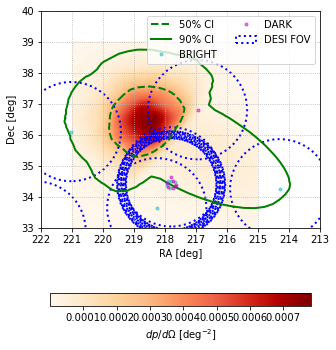

In [82]:
fig = plot_cartmap_tiles(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = tile_ras, targ_dec = tile_decs, angsize = 3, program_names = program_info)
ax = fig.gca()
ax.set(xlim=(222, 213), ylim=(33,40))
plt.savefig(gw_name + '_desi_tile-matches.png', dpi=120)

In [27]:
todayy = Time.now()
print(str(todayy).split(" ")[0])

2021-06-04
